<h2>Photo-z validation metrics on Resampled Cosmos Data for Y1</h2>

This notebook shows how to load a .yaml /.p pickle file from the Cosmos validation files. [Alahambra will appear in Y3]

We then determine the error, from the Cosmic Variance analysis. We do not have other sources of error, which are all subsumed in the generation of the validation files.

You will need to change the *path* and *path_to_pickle_output_file*  lines in the below cell

Details about the training, validation and science samples can be found here: [usual des u/p]

http://129.187.203.185/~hoyleb/DES/PHOTOZ/NGMIX/readme.txt



In [53]:
import yaml
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import pickle
import bz2
import copy
import bh_photo_z_validation as pval
path = '/Users/hoyleb/Documents/python/modules/photoz-wg/validation/'

#these are the current template and ML codes scores. Can you beat them!
#[WL_CLASS.MOF.ML0.p, WL_CLASS.COADD.p, LSS_CLASS.COADD.p, LSS_CLASS.MOF.p
#LSS_CLASS.COADD.bpz.p LSS_CLASS.MOF.bpz.p   WL_CLASS.COADD.bpz.p  
#WL_CLASS.MOF.bpz.p    Y1_CLASS.COADD.bpz.p  Y1_CLASS.MOF.bpz.p

#point_COSMOSnonNGMIX point_COSMOSnonNGMIX.p
path_to_pickle_output_file = path + 'WL_CLASS.MOF.ML.p'

path_to_cos_var_pickle_file = path + 'cosmic_variance_data/cosvariance_cosmos_z_metrics.zbins.p.bz2'
#path_to_cos_var_pickle_file = path + 'cosmic_variance_data/cosvariance_cosmos_z_metrics1cos2alh.zbins.p.bz2'

#cosvariance_cosmos_z_metrics1cos2alh.zbins.p.bz2
#cosvariance_cosmos_z_metrics.zbins.p.bz2


In [54]:
class scaled_error():
    def __init__(self, const, scaling_type):
        self.const = const
        self.scaling = None
        if scaling_type == 'one_plus_z':
            self.scaling = self.one_plus_z 
        else:
            self.scaling = self.const_with_z
        
    def one_plus_z(self, z):
        return np.array((1 + z) * self.const)
    
    def const_with_z(self, z):
        return np.array(len(z) * [self.const])
    

In [55]:
#some plotting routines
almost_black = '#262626'
plt.rcParams['figure.figsize'] = (24,12)
plt.rcParams.update({'font.size': 36, 
                     'axes.linewidth': 5,
                    'text.color': almost_black,
                    'xtick.major.size': 4,
                    'ytick.major.size': 4,
                    'legend.fancybox': True,
                    'figure.dpi': 300,
                    'legend.fontsize': 22,
                    'legend.framealpha': 0.8,
                    'legend.shadow': True,
                    'xtick.labelsize': 28,
                    'ytick.labelsize': 28})

<h3>Metrics of interest</h3>

Let us decide which metrics we want to measure. Edit this list with metrics that we measured from the validation script. Look at the structure of the validation .yaml file to understand this indexing.

In [56]:
#metrics to plot.
#'metric_name': [WHICH_Z_COLUMN, WAY_TO_COMPARE_DISTs, METRIC, [,MEASURED_ON]]
metrics = {'sigma_68': ['MEAN_Z', 'metrics_diffz','bh_photo_z_validation.sigma_68', 'delta_z'],
           'outFrac_2sigma68': ['MEAN_Z', 'metrics_diffz', 
                                'bh_photo_z_validation.outFrac_2sigma68', 'delta_z'],
           'outFrac_3sigma68': ['MEAN_Z', 'metrics_diffz', 
                                'bh_photo_z_validation.outFrac_3sigma68', 'delta_z'],
           'median': ['MEAN_Z', 'metrics_diffz', 'numpy.median', 'delta_z'],
           'wl_metric': ['Z_MC', 'metrics_z1_z2', 'bh_photo_z_validation.wl_metric']
           }

#which bining column should we choose?
bin_column = 'MEAN_Z'

#requirements from science handbook
# http://des-docdb.fnal.gov:8080/cgi-bin/RetrieveFile?docid=20&filename=sciReq-9.86.pdf&version=32
# http://des-docdb.fnal.gov:8080/cgi-bin/ShowDocument?docid=1719
requirements = {'sigma_68':{'value': 0.12, 'error': scaled_error(0.003, 'const')},
                'wl_metric': {'value': 0.02, 'error': scaled_error(0.003, 'const')},
                'outFrac_2sigma68': { 'value': 0.1 , 'error': scaled_error(0.001, 'const') },
                'outFrac_3sigma68': {'value': 0.015, 'error': scaled_error(0.0015, 'const') },
                'median': {'value': 0, 'error': scaled_error(0.001, 'one_plus_z') },
                }

#plotting ranges
plt_range = {'sigma_68': [0, 0.5],
            'wl_metric': [0, 0.1],
            'outFrac_2sigma68': [0, 0.3],
            'outFrac_3sigma68': [0, 0.3],
             'median' : [-0.2, 0.2]
            }

metric_latex = {
    'sigma_68' :'$\sigma_{68}(z_{true} - z_{pred})$',
    'wl_metric': '$|<dNdz_{true}> - <dNdz_{pred}>|$',
    'outFrac_2sigma68': '$f(>2*\sigma_{68})$',
    'outFrac_3sigma68': '$f(>3*\sigma_{68})$',
    'median' : '$\mu(z_{true} - z_{pred})$'
}

In [57]:
bns_str = '[0, 0.1, 0.2, 0.43, 0.63, 0.9, 1.3]'.replace(' ','')

<h3>Load results files</h3>

Now let's load the .p [pickle] file output from the validation pipeline, and also the cosmic variance results we calculated elsewhere [Ask Youngsoo/Ben/Markus for details].


In [58]:
if path_to_pickle_output_file[-4:] == '.bz2':
    res = pickle.load(bz2.BZ2File(path_to_pickle_output_file, 'r'))
else:
    res = pickle.load(open(path_to_pickle_output_file, 'r'))

cosvar = pickle.load(bz2.BZ2File(path_to_cos_var_pickle_file, 'r'))

test_dict = cosvar[0][bns_str]['test']

#get the original bins in the test .yaml file
bins = np.array(eval(test_dict['bins'][0][bin_column]))

In [59]:
files = res.keys()
def get_val(dct, ky):
    return dct[ky]

sample = files[0].split('/')[-1].split('rescaled')[0]

code = 'ML'
if 'bpz' in files[0]:
    code = 'TPL'
    
print (sample + ' ' + code)

WL_CLASS.MOF. ML


In [60]:
#get the error component from the resampled Alhambra data
    
m_res = {} #temporary value storage
metric_res = {} #this holds the median metric value, and std from the RS samples. Also the binned results

for m in metrics.keys():
    met_kys = metrics[m]
    m_res[m] ={'VALUES': [], 'BINS_ID': {}}
    metric_res[m] = {'VALUES':[], 'BINS_ID': {}}

    f  = files[0]
    test_name = res[f].keys()[0]
    for j, ky in enumerate(met_kys):
        if j ==0:
            dct = get_val(res[f][test_name], ky)
        else:
            dct = get_val(dct, ky)

    #get the unbinned value
    metric_res[m]['VALUES'] = dct['VALUE']

    #Each resampled file can have a different <z> per bin, so find the 
    #index of the original bins [in test.yaml] that corresponds to this redshift
    for j, zbn in enumerate(dct['bins'][bin_column]['BIN_CENTERS']):
        if np.isfinite(zbn) and zbn > 0:
            indj = np.where((zbn < bins[1:]) * (zbn >= bins[0:-1]))[0][0]
            if indj not in m_res[m]['BINS_ID']:
                metric_res[m]['BINS_ID'][indj] = {}
            
            metric_res[m]['BINS_ID'][indj]['BIN_CENTER'] = zbn
            
            #we don't current calcaulte boot strapp errors on wl_metric
            if m == 'wl_metric':
                metric_res[m]['BINS_ID'][indj]['SIGMA_BS'] = 0
                metric_res[m]['BINS_ID'][indj]['VALUE_BS'] = dct['bins'][bin_column]['VALUE'][j]
            else:
                metric_res[m]['BINS_ID'][indj]['VALUE_BS'] = dct['bins'][bin_column]['MEAN_BS'][j]
                metric_res[m]['BINS_ID'][indj]['SIGMA_BS'] = dct['bins'][bin_column]['SIGMA_BS'][j]

<h3>Next add in CosmicVariance error component</h3>

We repeat the above, and additionally calculate the error on each metric from cosmic variance. and from validating on high quality photo-z instead of spec-z

In [61]:
#this will hold the median metric values from cosmic variance
sample_var_truez = {}

for m in metrics.keys(): 
    met_kys = metrics[m]
    sample_var_truez[m] = {'VALUES':[], 'BINS_ID': {}}
    
    #we only care about the bin numbers that we have measured data in
    for j, indj in enumerate(metric_res[m]['BINS_ID']):
        sample_var_truez[m]['BINS_ID'][indj] = {}
        sample_var_truez[m]['BINS_ID'][indj]['VALUE'] = []
        sample_var_truez[m]['BINS_ID'][indj]['BIN_CENTER'] = []
  
    #loop over all simulated files.
    for f in cosvar:
        for j, ky in enumerate(met_kys):
            if j ==0:
                z_dct = get_val(f[bns_str]['Z'], ky)
            else:
                z_dct = get_val(z_dct, ky)

        #get the value for all unbinned data        

        sample_var_truez[m]['VALUES'].append(z_dct['VALUE'])

        for j, zbn in enumerate(z_dct['bins'][bin_column]['BIN_CENTERS']):  
            indj = np.where((zbn < bins[1:]) * (zbn >= bins[0:-1]))[0][0]
            
            if indj in sample_var_truez[m]['BINS_ID'].keys():
                sample_var_truez[m]['BINS_ID'][indj]['BIN_CENTER'].append(z_dct['bins'][bin_column]['BIN_CENTERS'][j])
                sample_var_truez[m]['BINS_ID'][indj]['VALUE'].append(z_dct['bins'][bin_column]['VALUE'][j])
            
    
    #calculate the 68% spread of these metric values
    sample_var_truez[m]['SIGMA']  = pval.sigma_68(sample_var_truez[m]['VALUES'])
    sample_var_truez[m]['VALUES']  = np.median(sample_var_truez[m]['VALUES'])
    
    #for each bin number, calculate the bin center, sigmas and mean value
    for j, indj in enumerate(sample_var_truez[m]['BINS_ID']):
        sample_var_truez[m]['BINS_ID'][indj]['BIN_CENTER'] = np.median(sample_var_truez[m]['BINS_ID'][indj]['BIN_CENTER'])
        sample_var_truez[m]['BINS_ID'][indj]['SIGMA'] = pval.sigma_68(sample_var_truez[m]['BINS_ID'][indj]['VALUE'])
        sample_var_truez[m]['BINS_ID'][indj]['VALUE'] = np.median(sample_var_truez[m]['BINS_ID'][indj]['VALUE'])
   

<h3>Plot both error components</h3>

Let's add the cosmic variance error in quadrature to the ReSample error, and plot the results for each metric, as a function of the tomographic bins.

MLWL_CLASS.MOF.
metric: | outFrac_3sigma68
Mean & Combined Err (BootStrap Err \pm SampVar Err)  \\
0.0601 \pm \bf 0.0076  ( 7.1e-03 \pm 2.8e-03) \\ 
metric: | outFrac_2sigma68
Mean & Combined Err (BootStrap Err \pm SampVar Err)  \\
0.1238 \pm \bf 0.0142  ( 1.4e-02 \pm 2.8e-03) \\ 
metric: | median
Mean & Combined Err (BootStrap Err \pm SampVar Err)  \\
-0.0210 \pm \bf 0.0064  ( 1.9e-03 \pm 6.1e-03) \\ 
metric: | sigma_68
Mean & Combined Err (BootStrap Err \pm SampVar Err)  \\
0.1698 \pm \bf 0.0101  ( 3.1e-03 \pm 9.6e-03) \\ 
metric: | wl_metric
Mean & Combined Err (BootStrap Err \pm SampVar Err)  \\
0.0092 \pm \bf 0.0107  ( 0.0e+00 \pm 1.1e-02) \\ 


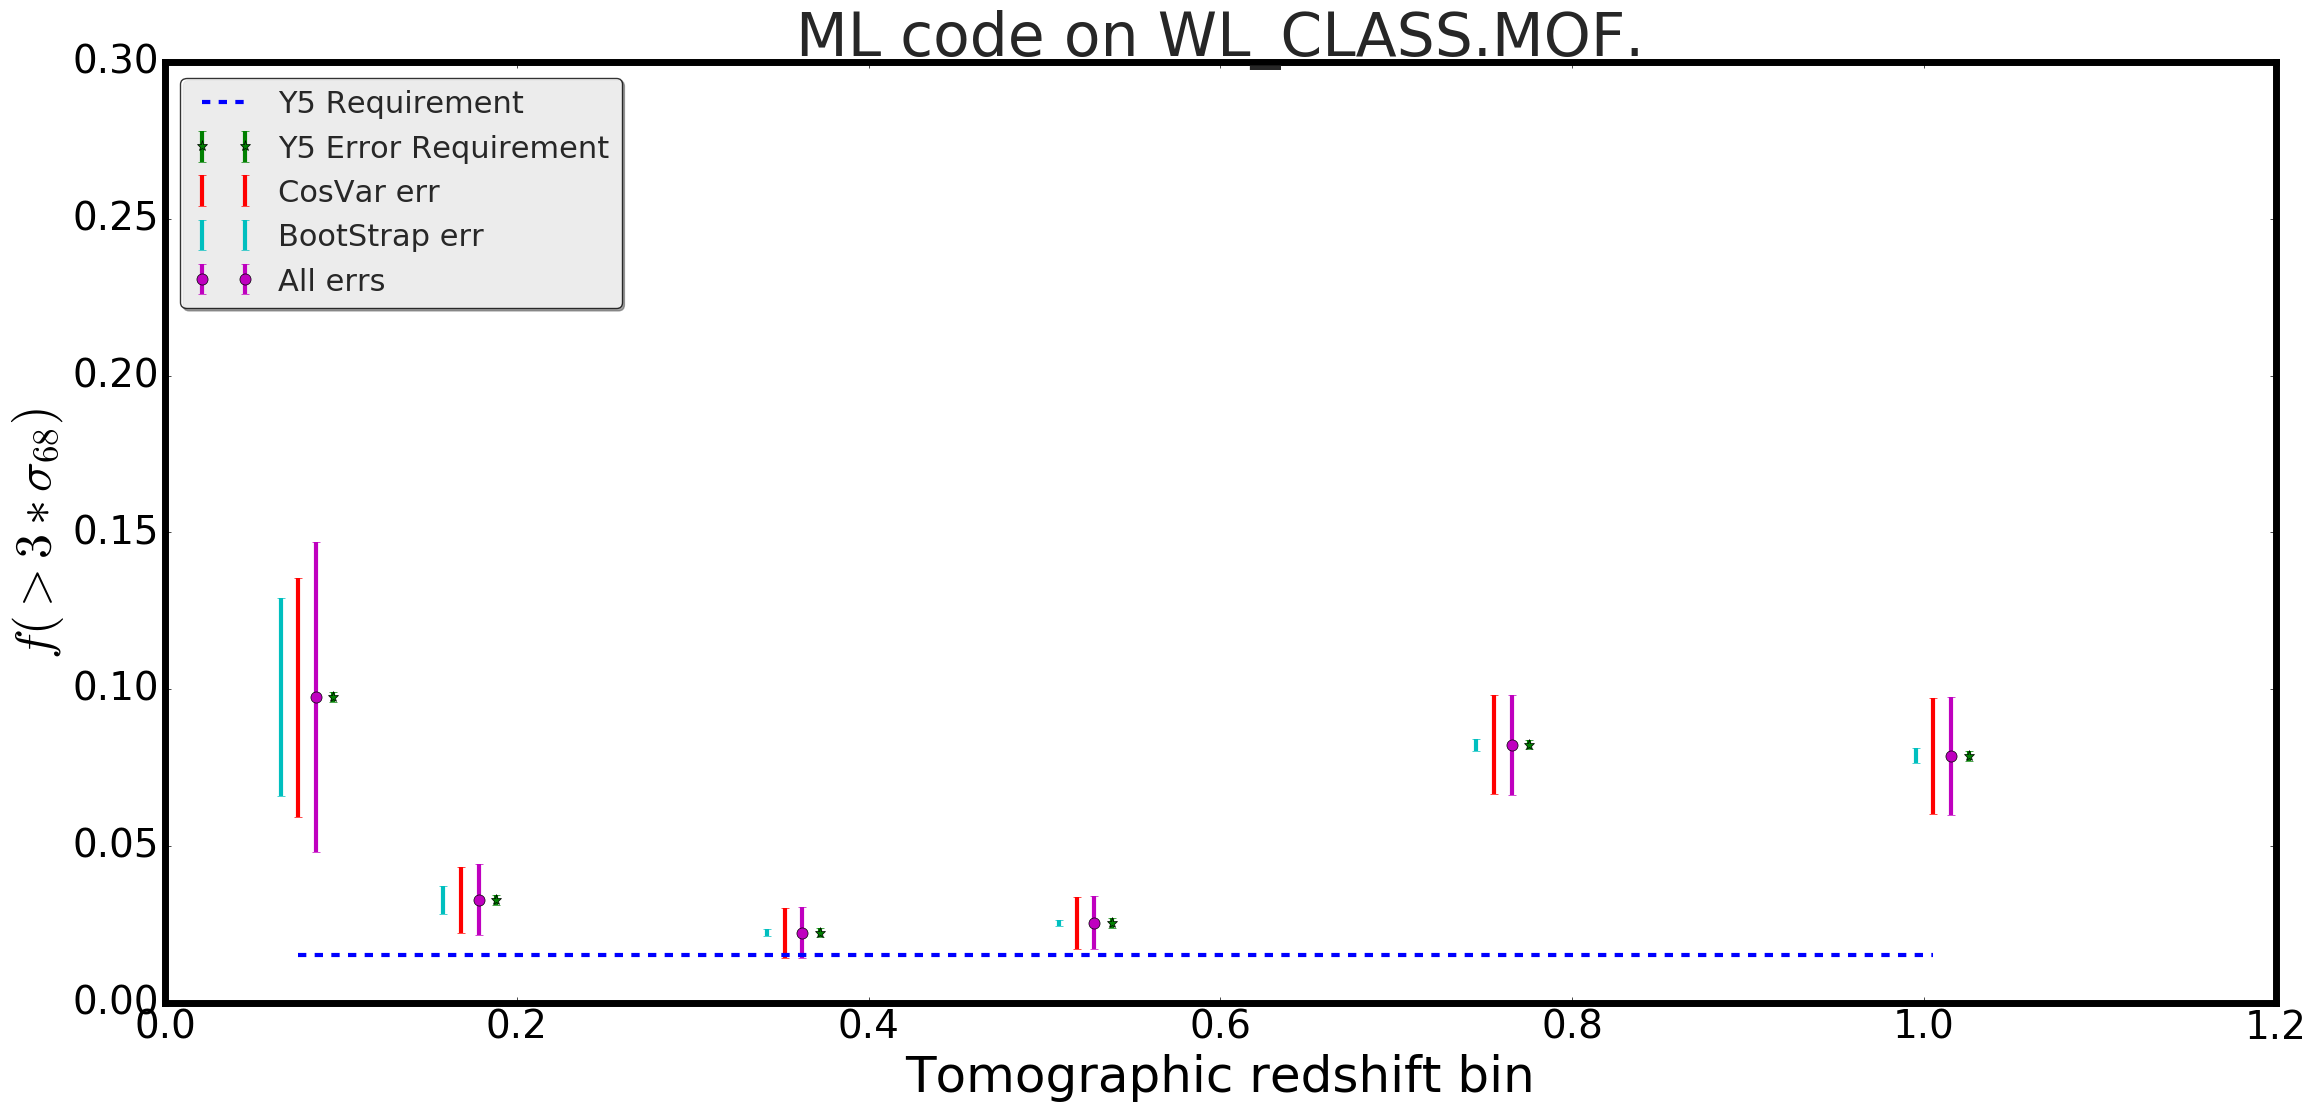

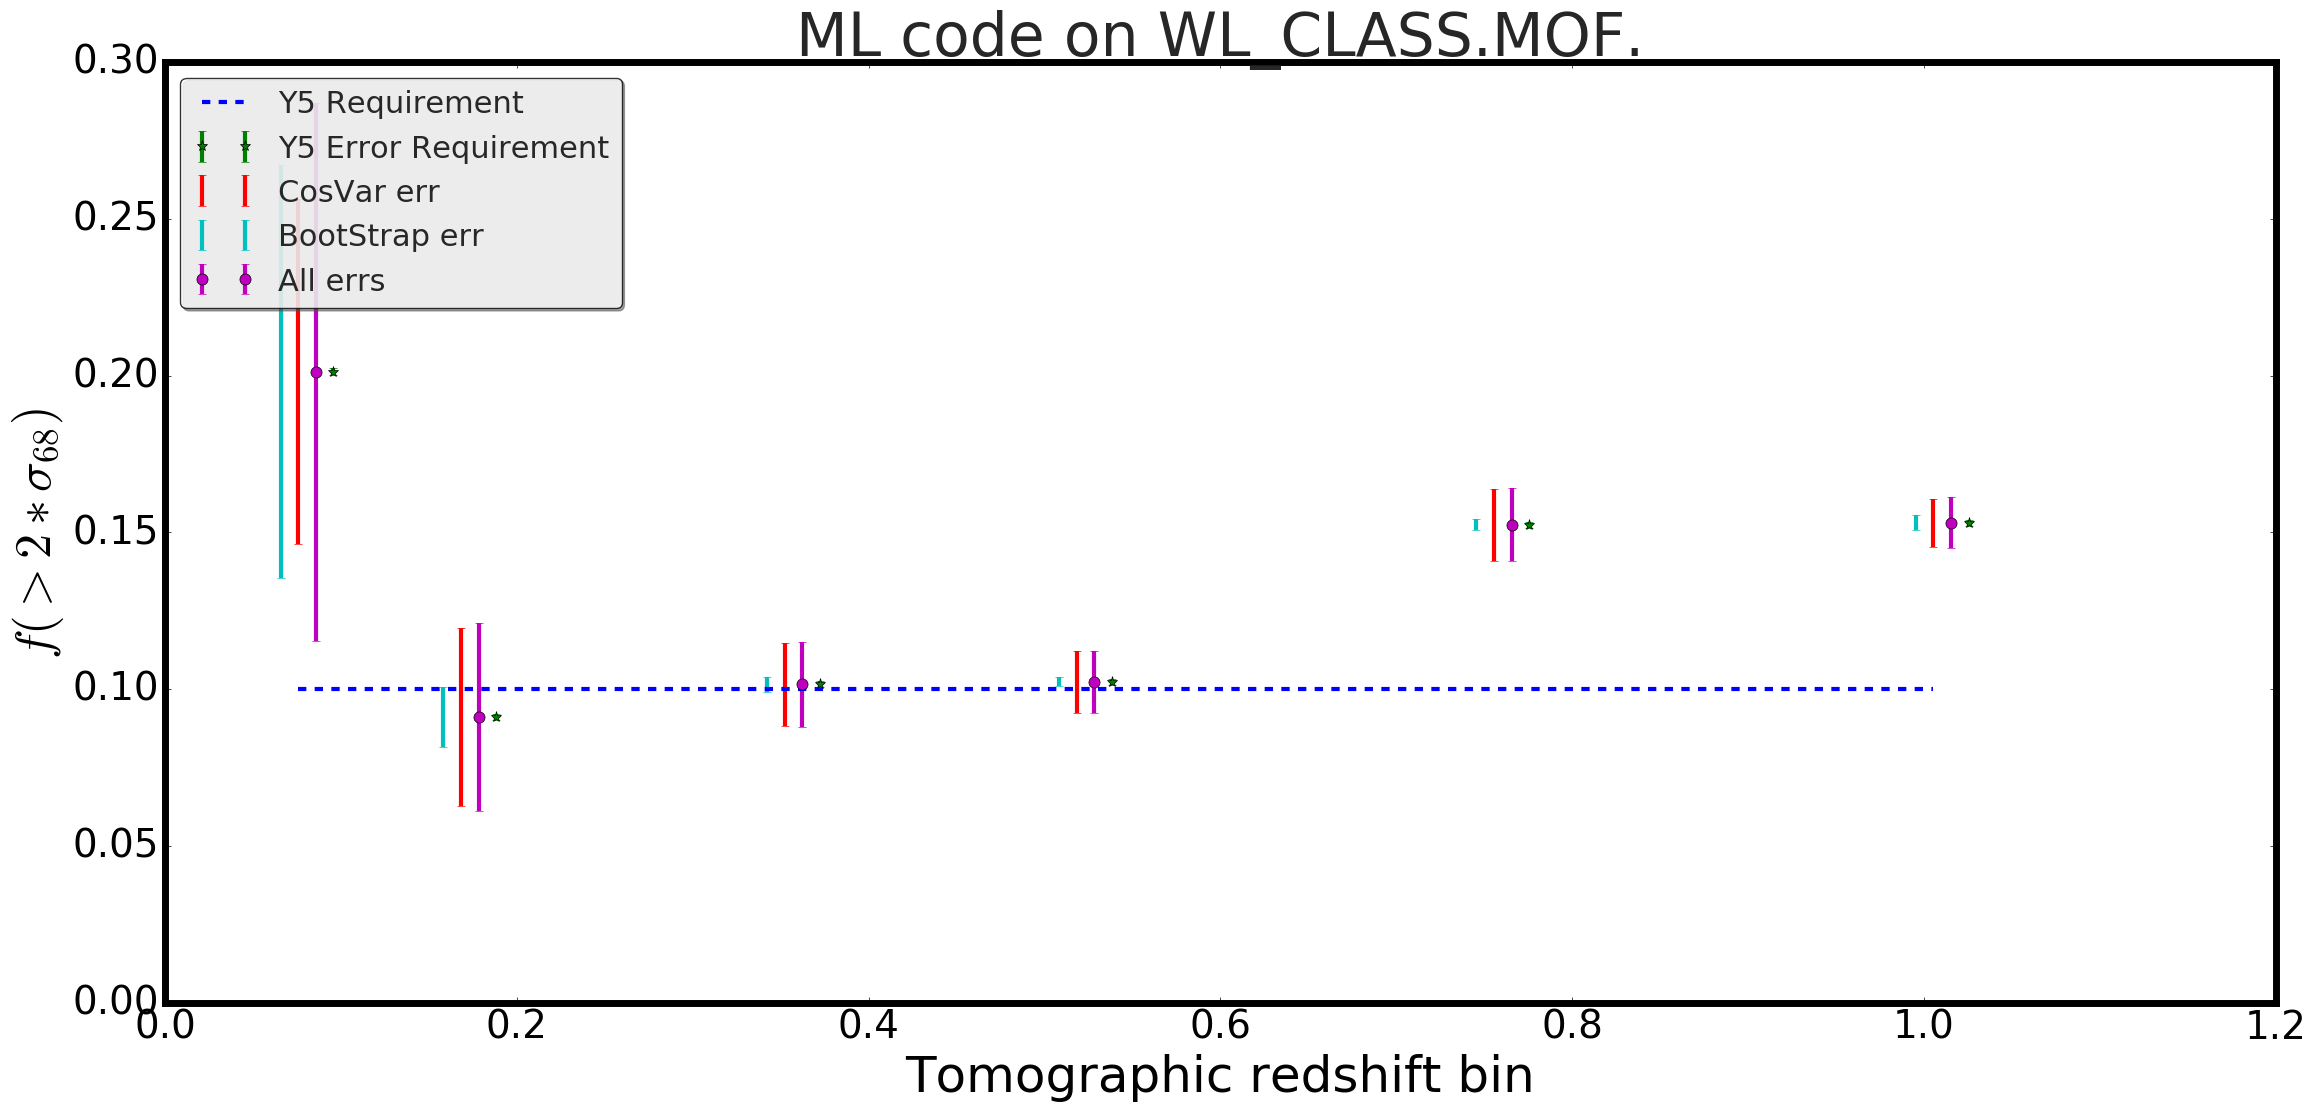

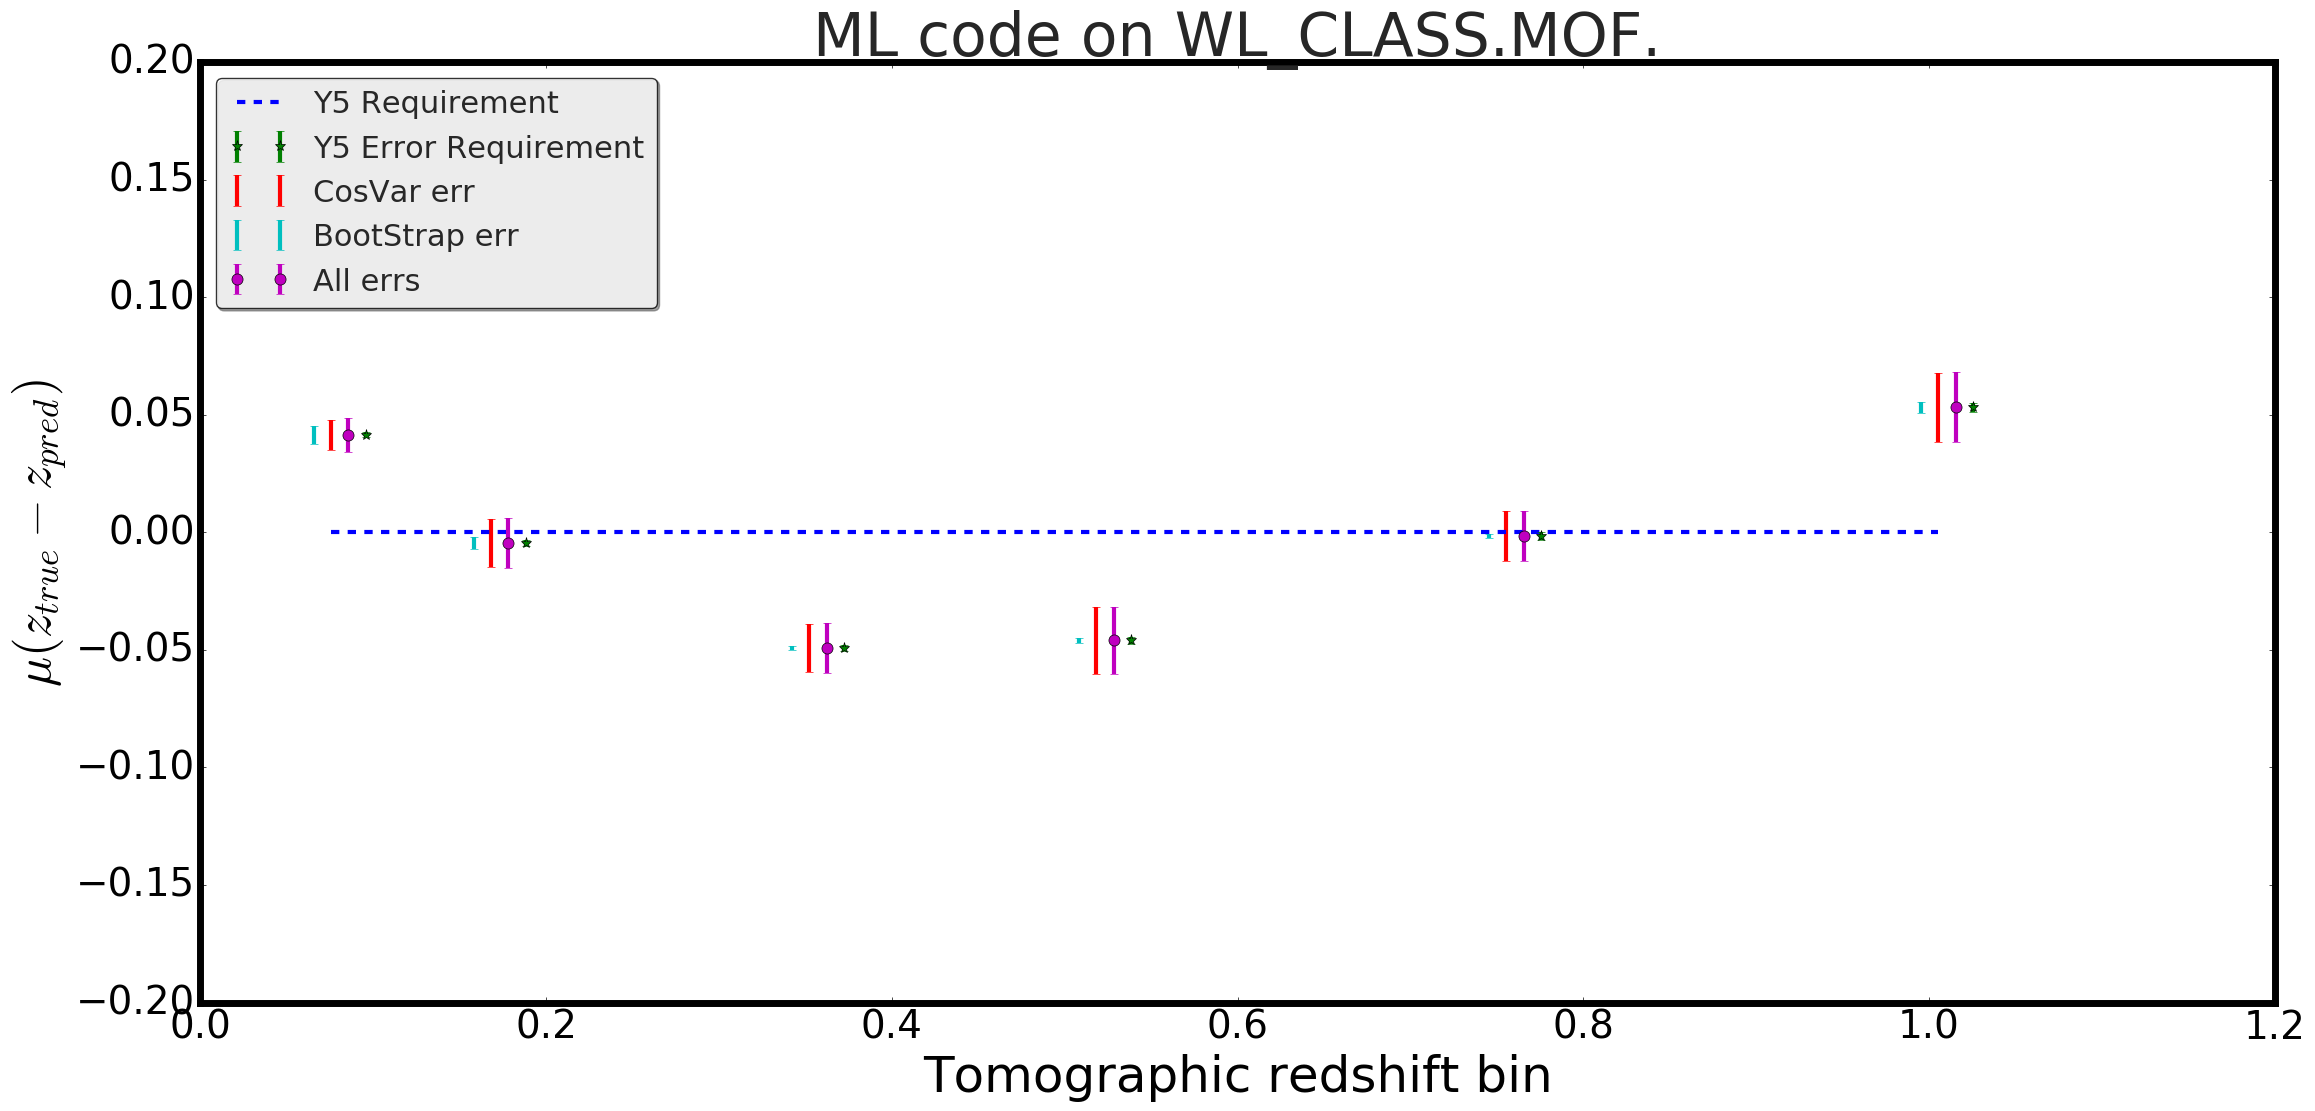

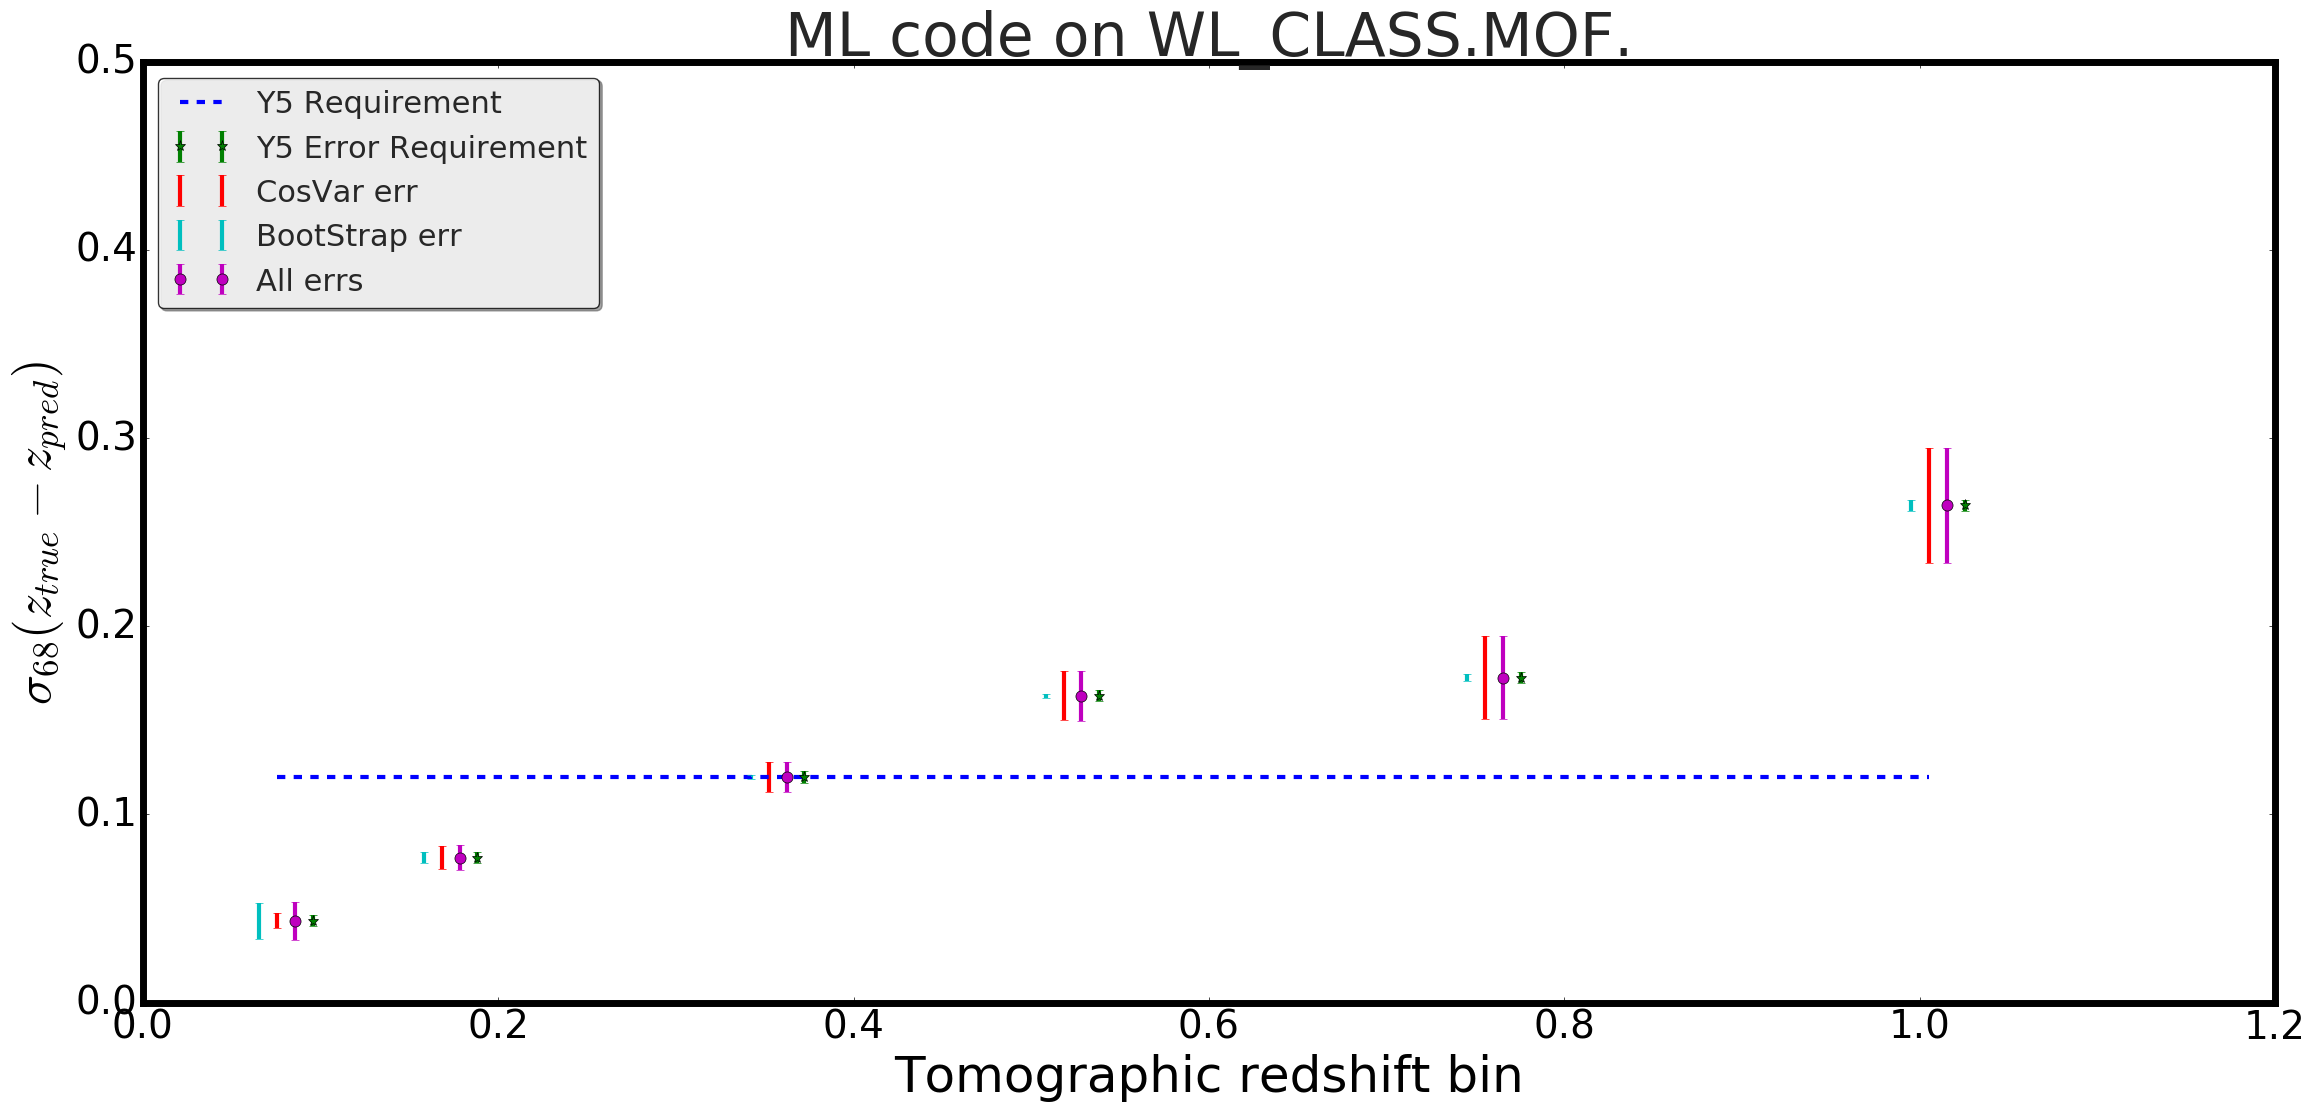

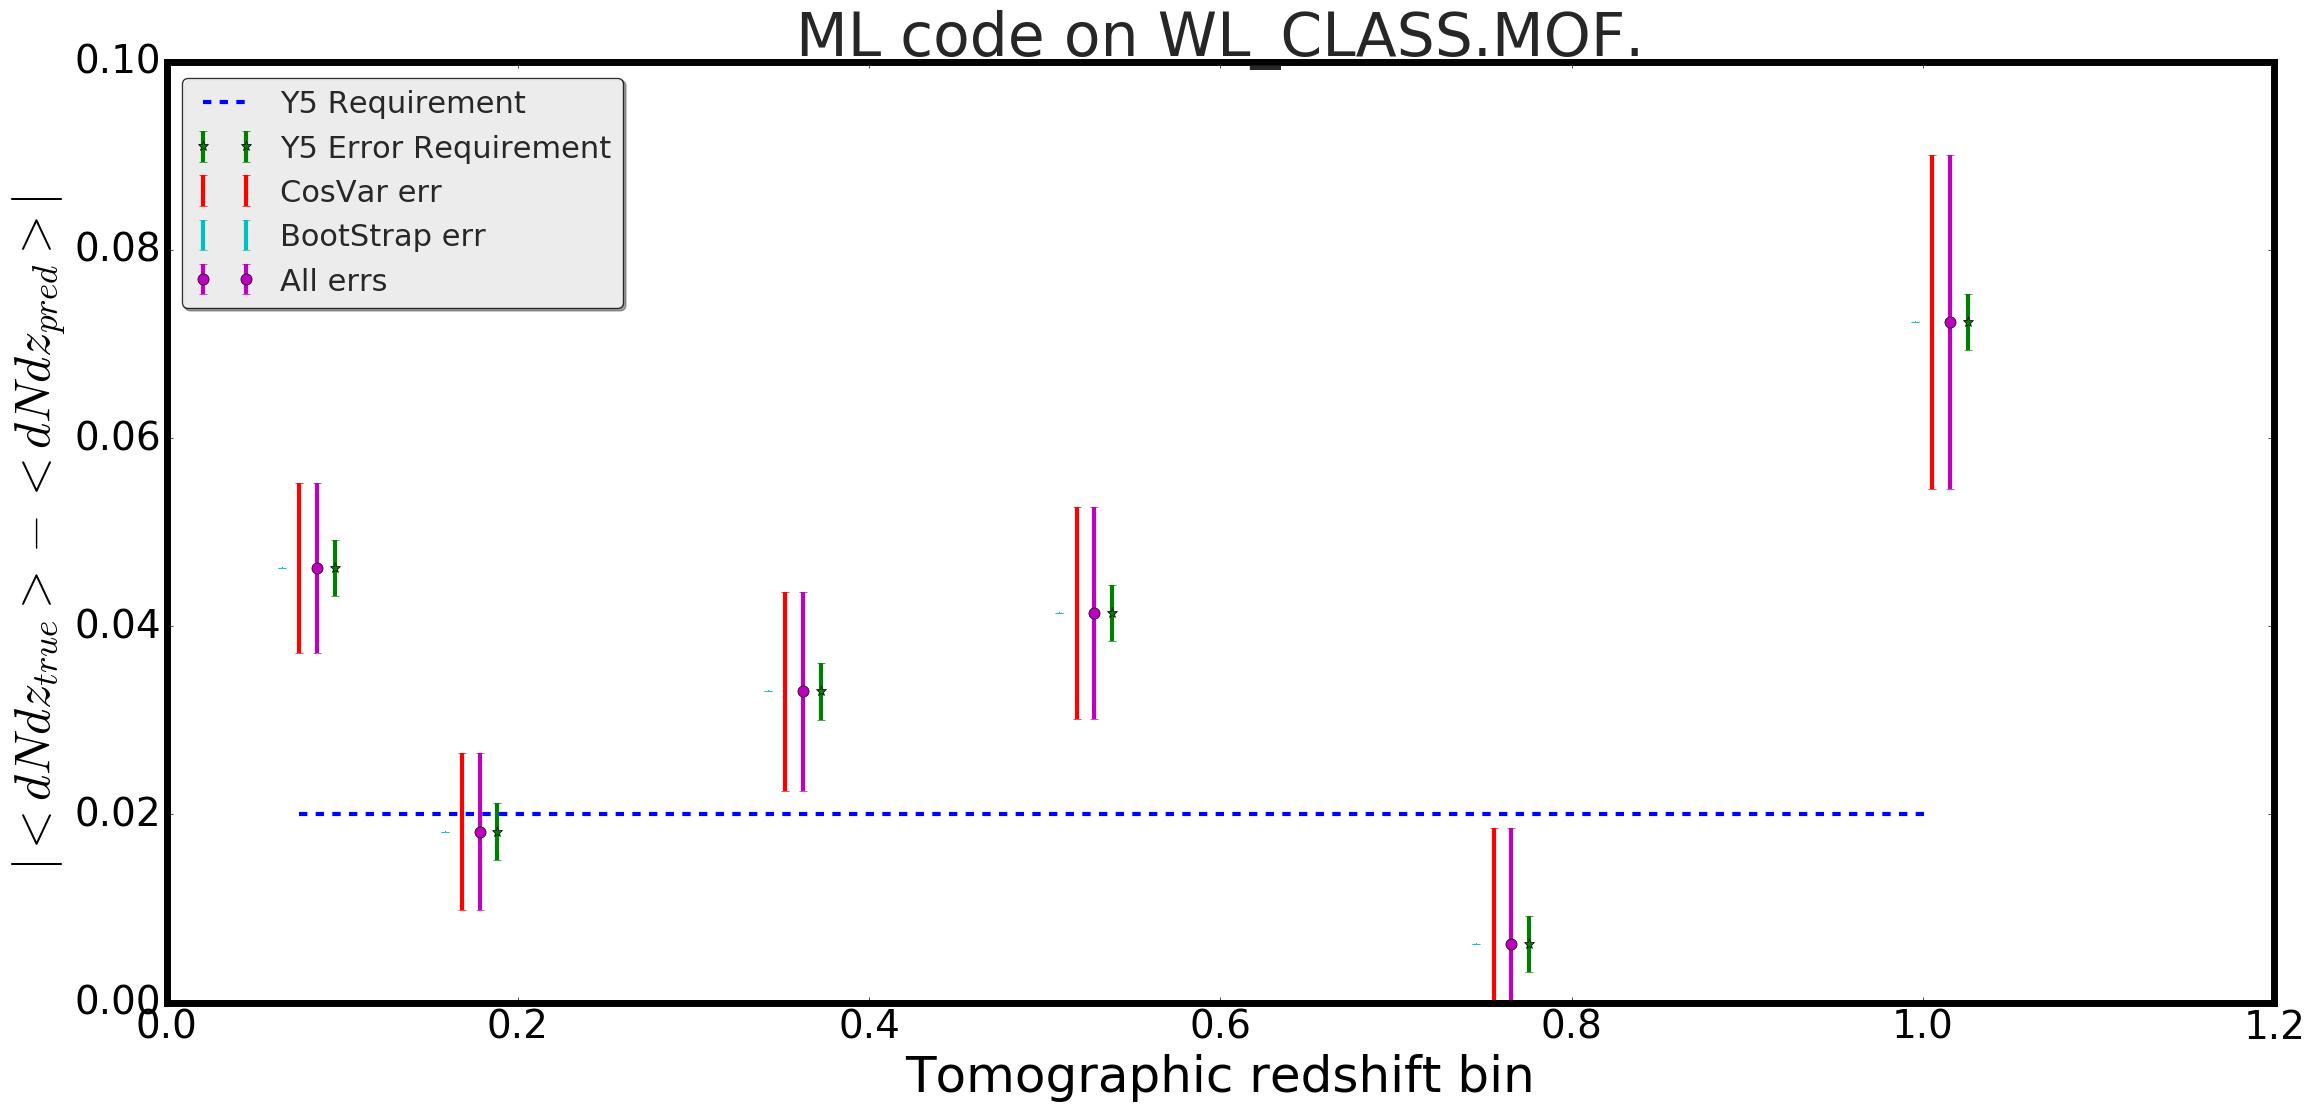

In [62]:
#For potting
#markersize
Ms = 8
#linewidth
lw = 3

print (code + sample)

cos_vv = {}
for m in metric_res:
    f= plt.figure()
    indjs = metric_res[m]['BINS_ID'].keys()
    z = np.array([metric_res[m]['BINS_ID'][indj]['BIN_CENTER'] for indj in indjs])
    errBS = np.array([metric_res[m]['BINS_ID'][indj]['SIGMA_BS'] for indj in indjs]) #err from BoostStrap
    errCV = np.array([sample_var_truez[m]['BINS_ID'][indj]['SIGMA'] for indj in indjs]) #err from CosVar to photo-z

    cos_vv[m] = errCV
    err = np.sqrt(errBS**2 + errCV**2) #add in quadrature
    y = np.array([metric_res[m]['BINS_ID'][indj]['VALUE_BS'] for indj in indjs])

        #get requirements:
    if m in requirements:
        val_req = [requirements[m]['value']]*len(z)
        plt.plot(np.array(np.sort(z)), val_req,'--', linewidth=3,label='Y5 Requirement')
        
        err_req = requirements[m]['error'].scaling(np.array(z))
        plt.errorbar(np.array(z)+0.02, y, yerr=err_req, fmt='*',markersize=str(Ms), elinewidth=lw, label='Y5 Error Requirement')
        
    
    #plot the different error components
    plt.errorbar(np.array(z), y, yerr=errCV , fmt=',',markersize=str(Ms), elinewidth=lw, label='CosVar err')
    plt.errorbar(np.array(z)-0.01, y, yerr=errBS, fmt=',', markersize=str(Ms), elinewidth=lw,label='BootStrap err')
    plt.errorbar(np.array(z)+0.01, y, yerr=err, fmt='o',markersize=str(Ms), elinewidth=lw, label='All errs')
    

    plt.xlabel('Tomographic redshift bin')
    plt.title(code + ' code on ' + sample)
    plt.ylim(plt_range[m])
    plt.ylabel(metric_latex[m])
    plt.legend(loc=2)
    plt.tight_layout()
    plt.savefig(code + sample + m + '.pdf')
    
    #print to screen a ~latex formatted set of results
    print ('metric: | {:}'.format(m))
    mean = metric_res[m]['VALUES']
    errBS = np.mean(errBS[np.isfinite(errBS)])
    cosVarErr = sample_var_truez[m]['SIGMA']
    err = np.sqrt(errBS**2 + cosVarErr**2 )
    print ('Mean & Combined Err (BootStrap Err \pm SampVar Err)  \\\\')
    print ('{:0.4f} \pm \\bf {:0.4f}  ( {:0.1e} \pm {:0.1e}) \\\\ '.format(mean, err, errBS, cosVarErr))

<h3>That's it! you're done.</h3>

Share you results with the redshift wg.



<h3>Generating the sample (cosmic) variance</h3>

This code snippet loads in a heap of validation script outputs, measured on each patch in a simulation, and stores the resulting list in the cosmic variance file in the validation directory.

In [ ]:
#only execute this cell, if you have the raw results from the cosmic variance file
if False:
    files = glob.glob('/Users/hoyleb/DATA/DES/PHOTOZ/COSMIC_VAR/Cosmo_*.p')
    files = [i for i in files if 'Alh' not in i and 'e5' not in i and 'subsample' not in i]
    res = []
    for fil in files:
        r = pickle.load(open(fil, 'r'))
        res.append(r)
    print len(res)
    pickle.dump(res, bz2.BZ2File(path + '/cosmic_variance_data/cosvariance_cosmos_z_metrics.zbins.p.bz2', 'w'))


    files = glob.glob('/Users/hoyleb/DATA/DES/PHOTOZ/COSMIC_VAR/Cosmo_1xAlh*.p')
    res = []
    for fil in files:
        r = pickle.load(open(fil, 'r'))
        res.append(r)
    print len(res)
    pickle.dump(res, bz2.BZ2File(path + '/cosmic_variance_data/cosvariance_cosmos_z_metrics1cos1alh.zbins.p.bz2', 'w'))

    files = glob.glob('/Users/hoyleb/DATA/DES/PHOTOZ/COSMIC_VAR/Cosmo_2xAlh*.redshift.metrics.p')
    files = [i for i in files if 'e5' not in i and 'subsample' not in i]
    res = []
    for fil in files:
        r = pickle.load(open(fil, 'r'))
        res.append(r)
    print len(res)
    pickle.dump(res, bz2.BZ2File(path + '/cosmic_variance_data/cosvariance_cosmos_z_metrics1cos2alh.zbins.p.bz2', 'w'))


In [ ]:
#only for cosmic variance analysis.
#run this script once with one cos-var file, then repeat [but not this cell] with the other cos var file.
cos_noalh = copy.deepcopy(cos_vv)

In [ ]:
mm = ['wl_metric', 'sigma_68', 'median', 'outFrac_2sigma68']
col = ['red', 'blue', 'grey', 'purple']

f = plt.figure()
cnt=0
for m in mm:
    plt.plot(z, cos_noalh[m], '--',color=col[cnt], label=m, linewidth=10)
    plt.plot(z, cos_vv[m] , 'o-', color=col[cnt], linewidth=3 ,markersize=20 )
    
        #get requirements:
    if m in requirements:
        err_req = requirements[m]['error'].scaling(np.array(z))
        plt.plot(np.array(z), err_req, '*-', color=col[cnt], linewidth=1,markersize=25 )
    cnt += 1    
plt.legend()
plt.xlabel('Tomographic redshift bins ranges')
plt.ylabel('CosVar uncertainty')   
plt.savefig('CosVarianceReductionWith2xALH_requirement.pdf')